In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy.sparse
import scipy.linalg

# Steady State Heat Equation

Consider the following Steady State Heat Conduction problem in two dimension, $\textbf{x} = (x,y) \in \Omega \subset R^2$

$$
\begin{cases}
    - \nabla \cdot (q(\textbf{x}) \nabla u(\textbf{x})) = f(\textbf{x}) \;\;\;\;\;\;\;\;\;  \textbf{x} \in \Omega \\
    u(\textbf{x}) = g(\textbf{x}) \;\;\;\;\;\;\;\;\;  \textbf{x} \in \partial \Omega
\end{cases}
$$
After performing for the external divergence a centrate finite difference and for the internal gradient a backward finite difference, we obtain a formula analogous to the five point scheme used for the the Posson Equation

$$
   q_{i-1,j}u_{i-1,j} + q_{i,j-1}u_{i,j-1} - \left( q_{i-1,j} + q_{i,j-1} + q_{i,j+1} + q_{i+1,j} \right) u_{i,j} + q_{i,j+1}u_{i,j+1} + q_{i+1,j}u_{i+1,j} = - h^2 f_{i,j}  ;\;\;\;i=1,\dots,N_x, \;\;\;\; j = 1,\dots, N_y
$$

and the update rule for the $(i,j)$-th element used in the iterative Jacobi method is

$$
  u_{i,j} =  \frac{q_{i-1,j}u_{i-1,j} + q_{i,j-1}u_{i,j-1}+q_{i,j+1}u_{i,j+1} + q_{i+1,j}u_{i+1,j}  +  h^2 f_{i,j}}{\left( q_{i-1,j} + q_{i,j-1} + q_{i,j+1} + q_{i+1,j} \right)} \;\;\;\;i=1,\dots,N_x, \;\;\;\; j = 1,\dots, N_y
$$

# Implementation
## Example

Consider the following problem setting 
$$ 
\Omega = (0,1)^2,
$$

$$
f(x,y) = 8\pi sin(2\pi x)*cos(2\pi y)
$$

$$
    g(0,y) = g(1,y) = 0 
$$

$$
g(x,0) =g(x,1) = sin(2\pi x) \;\;\; 0<x<1  
$$


In [120]:
# Parameters
n_x = n_y = 20
n = n_x*n_y
a = 0
b = 1
c = 0
d = 1

# Source term
def f(x,y):
    return 0
    return 8*np.pi**2*np.sin(2*np.pi*x)*np.cos(2*np.pi*y)

# Boundary terms
def g_top_bottom(x):
    return np.sin(2*np.pi*x)

def g_left_right():
    return 0

# Conductivity term NEW
def q(x,y):
    return x**2 + y**2 + 10
    #return 1
    #return np.sin(2*np.pi*x)*np.cos(2*np.pi*y)

# Exact solution
def u_ex(x,y):
    return np.sin(2*np.pi*x)*np.cos(2*np.pi*y)

## Define the grid
__Important__: the boundary condition are inverted here wrt the 1.0 notebook, due the way we have numerated the discrete nodes and built the relative matrix and vector to solve the relative linear system.

In [65]:
# Define the grid s.t. x_0 = a, x_n+1 = b, y_0 = c, y_n+1 = d
x = np.linspace(a, b, n_x+1+1)
y = np.linspace(c, d, n_y+1+1)
xv, yv = np.meshgrid(x, y)

# Set h -IMPORTANT
h = x[1]-x[0]

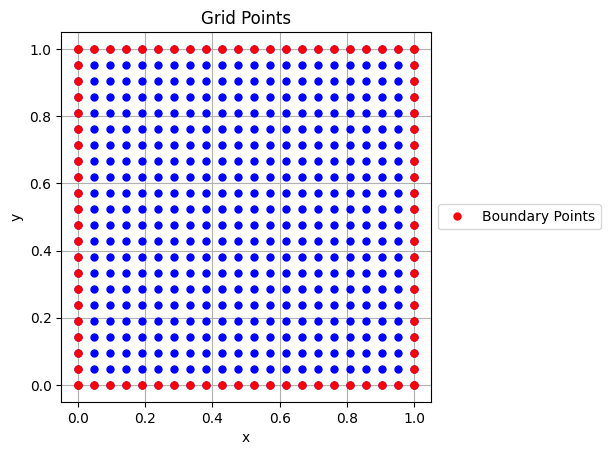

In [52]:
# Plot the grid
plt.plot(xv, yv, marker='o', linestyle='none', color='blue', markersize=5)

# Plot the boundary points
plt.plot(xv[:, 0], yv[:, 0], marker='o', linestyle='none', color='red', markersize=5, label='Boundary Points')  # Left boundary
plt.plot(xv[:, -1], yv[:, -1], marker='o', linestyle='none', color='red', markersize=5)  # Right boundary
plt.plot(xv[0, :], yv[0, :], marker='o', linestyle='none', color='red', markersize=5)  # Top boundary
plt.plot(xv[-1, :], yv[-1, :], marker='o', linestyle='none', color='red', markersize=5)  # Bottom boundary

plt.xlabel('x')
plt.ylabel('y')
plt.title('Grid Points')
plt.gca().set_aspect('equal', adjustable='box')
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

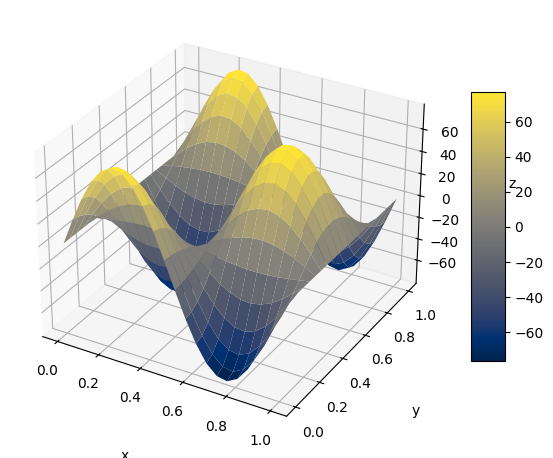

In [98]:
# Plot the source term f
z = f(xv, yv)
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xv, yv, z, cmap = plt.cm.cividis)

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

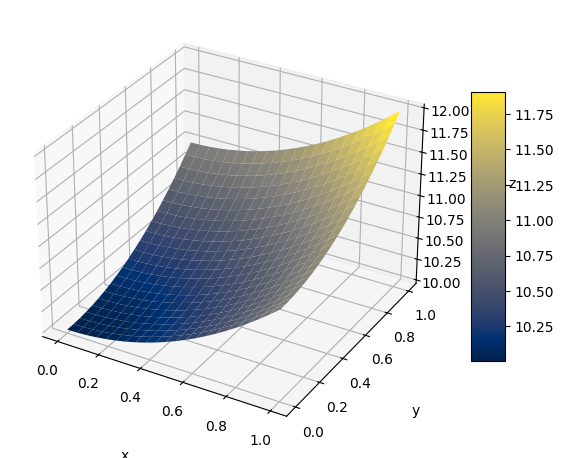

In [116]:
# Plot the conductivity term q
z = q(xv, yv)
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xv, yv, z, cmap = plt.cm.cividis)

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

## Define the boundary condition

In [60]:
# Set the boundary value of above defined approximated solution to the known boundary value
u_h = np.zeros((n_x+1+1,n_y+1+1))

# Left and Right boundary
for i in np.arange(n_x+2):
    u_h[i, 0] = g_top_bottom(x[i])#u_ex(x[i], y[0])#g_left_right() # Left
    u_h[i, n_y+1] = g_top_bottom(x[i]) #u_ex(x[i], y[n_y+1])#g_left_right() # Right

# Top and bottom boundary
for j in np.arange(n_y+2):
    u_h[0, j] = g_left_right() #u_ex(x[0], y[j])#g_top_bottom(x[j]) # Bottom
    u_h[n_x+1, j] = g_left_right()#u_ex(x[n_x+1], y[j])#g_top_bottom(x[j]) # Top


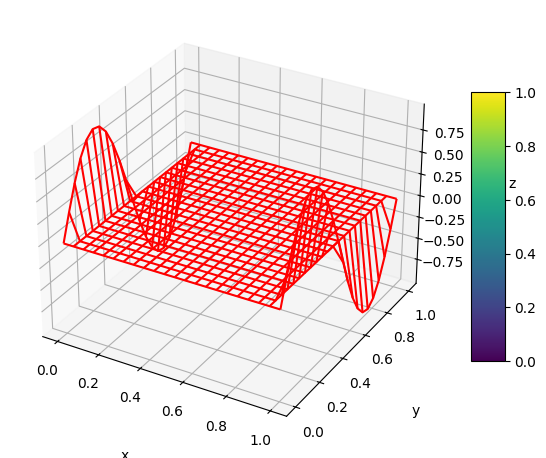

In [61]:
# Plot the boundary value
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
surf = ax.plot_wireframe(xv, yv, u_h,color='r')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

# Implement the finite difference solver

## Jacobi iterative method

In [121]:
# Parameters
max_iteration = 3000
it = 0
tolerance = 1e-3
residual_norm = 1
# History of the differences at each iteration
hist_differences = [residual_norm]
# Residuals
residuals = np.zeros((n_x+1+1,n_y+1+1))

# Initial guess - initialized to 0 in the interior node and with the right bundary condition
u_0 = np.copy(u_h) # in python variables are copied by reference! np.copy create a true copy

# Next iteration's solution
u_new = np.copy(u_0)

# Real solution
u_real = np.zeros((n_x+1+1,n_y+1+1))
for i in np.arange(0, n_x+2):
    for j in np.arange(0, n_y+2):
        u_real[i,j] = u_ex(x[i], y[j])

# Conductivity coefficent 
q_eval = np.zeros((n_x+1+1,n_y+1+1))
for i in np.arange(0, n_x+2):
    for j in np.arange(0, n_y+2):
        q_eval[i,j] = q(x[i], y[j])

In [122]:
# Jacobi
while residual_norm>tolerance:
    if it > max_iteration:
        print("Solution not converged to the desired tolerence within the maximum number of iteration")
        break 

    # Modify only the interior nodes to apply Dirichlet boundary conditions
    for i in np.arange(1, n_x+1):
        for j in np.arange(1, n_y+1):
            u_new[i,j] =  (q(x[i+1], y[j])*u_0[i+1,j] + q(x[i-1], y[j])*u_0[i-1,j] \
                                  + q(x[i], y[j+1])*u_0[i,j+1] + q(x[i], y[j-1])*u_0[i,j-1] \
                                      + ((h**2) * f(x[i], y[j]))) \
                                        / (q(x[i+1], y[j]) + q(x[i-1], y[j]) + q(x[i], y[j+1]) + q(x[i], y[j-1]))
        
    
    # Calculate residual
    for i in range(1, n_x+1): # all interior combinations of i,j
        for j in range(1, n_y+1):
            residuals[i,j] = f(x[i], y[j]) - ((q(x[i+1], y[j]) + q(x[i-1], y[j]) + q(x[i], y[j+1]) + q(x[i], y[j-1])) * u_0[i,j] \
                                              - q(x[i+1], y[j])*u_new[i+1,j] - q(x[i-1], y[j])*u_new[i-1,j] \
                                                  - q(x[i], y[j+1])*u_new[i,j+1] - q(x[i], y[j-1])*u_new[i,j-1]) / (h**2)
    #residuals = u_new - u_0
        
    # Identify residual infinity norm 
    residual_norm = np.max(np.abs(residuals))
    #print(residual_norm)

    u_0 = np.copy(u_new)

    it +=1
   
else:
    print("Reached convergence in ", it, " iterations")

Reached convergence in  737  iterations


# Results

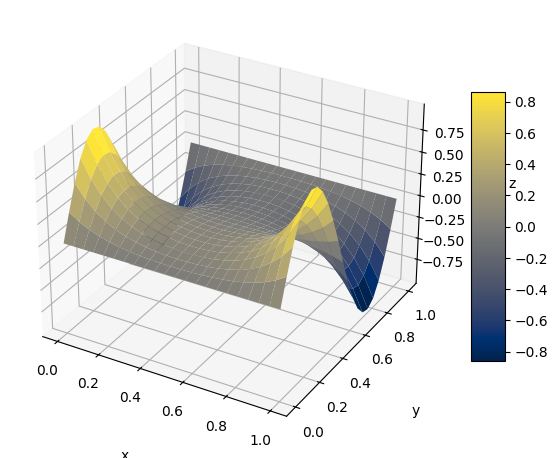

In [123]:
# Visualize the result
fig = plt.figure(figsize = (7,7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xv, yv, u_new, cmap = plt.cm.cividis)


# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

# References:
- https://aquaulb.github.io/book_solving_pde_mooc/solving_pde_mooc/notebooks/05_IterativeMethods/05_01_Iteration_and_2D.html